In [38]:
import numpy as np

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision
from torchvision import datasets, models, transforms

import os
import torch.nn.functional as F

import pandas as pd
import cv2
import glob

from matplotlib import pyplot as plt
!pip install livelossplot
from livelossplot import PlotLosses

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
data_dir = "/content/drive/My Drive/Colab Notebooks/data"
TRAIN = 'train'
TEST = 'test'

In [0]:
transformation = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    ])

In [0]:
image_datasets = {
    i: datasets.ImageFolder(os.path.join(data_dir, i),
                            transform = transformation
                            )
                for i in [TRAIN, TEST]
                }

In [0]:
X= torch.tensor([1,2,3])
Y=torch.tensor([4,5,6])
out = TensorDataset(X,Y)

In [21]:
out[2]

(tensor(3), tensor(6))

In [13]:
image_datasets['test'][52][1]

1

In [30]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=32,
        shuffle=True
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

Loaded 2656 images under train
Loaded 300 images under test
Classes: 
['C', 'L', 'fist', 'okay', 'palm', 'peace']


torch.Size([3, 122, 242])
(122, 242, 3)


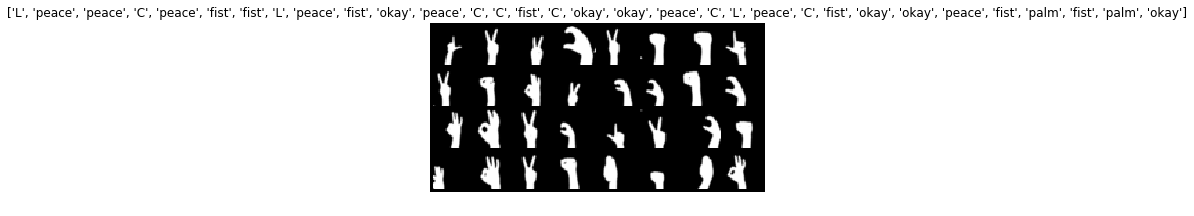

In [98]:
def imshow(inp, title=None):
    print(inp.shape)
    inp = inp.numpy().transpose((1, 2, 0))
    print(inp.shape)
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TEST]))
show_databatch(inputs, classes)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        #print('ok')
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(target.view_as(pred)).sum().item()
    
    avg_loss = train_loss / len(train_loader.dataset)
    avg_accuracy = train_correct / len(train_loader.dataset)
    

        
    #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
    #           epoch, batch_idx * len(data), len(train_loader.dataset),
    #            100. * batch_idx / len(train_loader), loss.item()))
    
    return avg_loss, avg_accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(target.view_as(pred)).sum().item()
    

    test_loss /= len(test_loader.dataset)
    avg_loss_val = test_loss
    avg_accuracy_val = test_correct / len(test_loader.dataset)

    
        

   # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #    test_loss, test_correct, len(test_loader.dataset),
    #    100. * test_correct / len(test_loader.dataset)))
    
    return avg_loss_val, avg_accuracy_val

In [34]:
model = Net()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
avg_loss, avg_accuracy = train(model, device, dataloaders['train'], optimizer, 1)


ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
Train Epoch: 1 [2624/2656 (99%)]	Loss: 1.621155


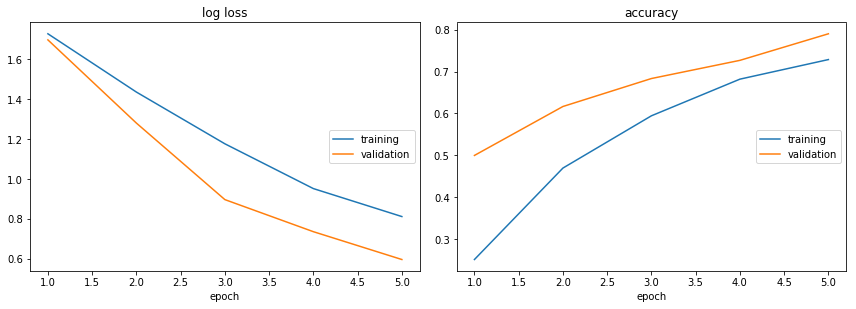

log loss:
training   (min:    0.811, max:    1.727, cur:    0.811)
validation (min:    0.596, max:    1.697, cur:    0.596)

accuracy:
training   (min:    0.252, max:    0.729, cur:    0.729)
validation (min:    0.500, max:    0.790, cur:    0.790)


In [119]:
model = Net()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

liveloss = PlotLosses()

for epoch in range(5):
    avg_loss, avg_accuracy = train(model, device, dataloaders['train'], optimizer, epoch)
    avg_loss_val, avg_accuracy_val = test(model, device, dataloaders['test'])
    
    liveloss.update({
        'val_log loss': avg_loss_val,
        'val_accuracy': avg_accuracy_val,
        'log loss': avg_loss,
        'accuracy': avg_accuracy,
    })
    
    liveloss.draw()

In [0]:
def imshow_new(inp, title=None):
    inp = inp.numpy().reshape(28,28)
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs_d = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs_d)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                #imshow(inputs.data[j])
                print(class_names[labels[j]])
                #print(j)
                imshow_new(inputs[j])
                #print(inputs.data[j].shape)
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)
                

peace


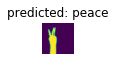

C


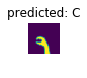

L


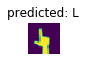

peace


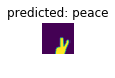

fist


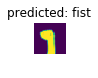

palm


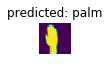

C


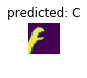

palm


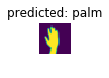

fist


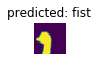

peace


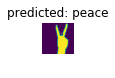

palm


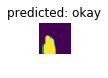

palm


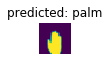

In [122]:
visualize_model(model,12)

In [0]:
torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/ready_model.pt")